In [17]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
[x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']


['device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0',
 'device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0',
 'device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0',
 'device: 3, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1e:00.0, compute capability: 7.0']

## Препроцессинг

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [2]:
labels = []
images = []
for cultures in glob("dataset/*"):
    for disease in glob(cultures+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            labels.append(disease.split('\\')[-1])
            images.append(img)


In [3]:
labels[1]

'dataset/Cucumbers/Anthracnose'

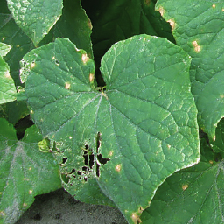

In [4]:
array_to_img(images[1])

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
n_labels = le.fit_transform(labels)
y = to_categorical(n_labels)
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
labels_count = np.unique(n_labels).size
labels_count

25

In [7]:
from tensorflow.keras.applications.resnet import preprocess_input
X = preprocess_input(np.array(images))

In [8]:
def mutate_images(n):
    dgen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,vertical_flip=True,
                               rotation_range=40)
    flow = dgen.flow(X, y)
    Xs = []
    yy = []
    for i in range(n):
        [c_x, c_y] = flow.next()
        print(f"({c_x.shape[0]}|{c_y.shape})", end="")
        Xs.append(c_x)
        yy.append(c_y)
    return np.concatenate(Xs), np.concatenate(yy)

In [9]:
Xs, ys = mutate_images(100)
Xs.shape, ys.shape

(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(6|(6, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(6|(6, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32|(32, 25))(32

((3122, 224, 224, 3), (3122, 25))

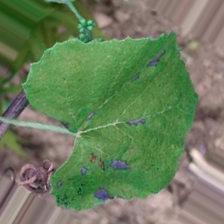

In [10]:
array_to_img(Xs[600,:,:,:])

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1) # поменял на исходные изображения

## Обучение

In [31]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf


In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть
    
    output = restnet.layers[-1].output # используем выход пердыдущего слоя
    output = tf.keras.layers.Flatten()(output) # видимо обертка
    restnet = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
    for layer in restnet.layers: # замораживаем предобученные слои модели
        layer.trainable = False
    
    head_input_shape = output.shape
    
    model = Sequential() #  собираем сеть из предобученныз слов и полносвязных слоев с отсечением в 0.3
    model.add(restnet)
    model.add(Dense(300, activation='relu', input_dim=head_input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(60, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(labels_count, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
                  optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
                  metrics=['accuracy'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 300)               30105900  
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 60)                18060     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_______

In [43]:
import datetime
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints/",
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X_train, y_train,
                    steps_per_epoch=y_train.shape[0],
                    epochs=5,
                    validation_data=(X_test, y_test), 
                    callbacks=[cp_callback, tensorboard_callback],
                    verbose=1)

Epoch 1/5
839/840 [============================>.] - ETA: 0s - loss: 0.9742 - accuracy: 0.7807
Epoch 00001: saving model to checkpoints/
840/840 [==============================] - 19s 23ms/step - loss: 0.9738 - accuracy: 0.7798 - val_loss: 1.9302 - val_accuracy: 0.6277
Epoch 2/5
840/840 [==============================] - ETA: 0s - loss: 0.9202 - accuracy: 0.7976
Epoch 00002: saving model to checkpoints/
840/840 [==============================] - 18s 22ms/step - loss: 0.9202 - accuracy: 0.7976 - val_loss: 1.8936 - val_accuracy: 0.6383
Epoch 3/5
838/840 [============================>.] - ETA: 0s - loss: 0.9024 - accuracy: 0.8007
Epoch 00003: saving model to checkpoints/
840/840 [==============================] - 18s 22ms/step - loss: 0.9078 - accuracy: 0.7988 - val_loss: 1.9558 - val_accuracy: 0.6170
Epoch 4/5
838/840 [============================>.] - ETA: 0s - loss: 0.8936 - accuracy: 0.8234
Epoch 00004: saving model to checkpoints/
840/840 [==============================] - 18s 22ms/s

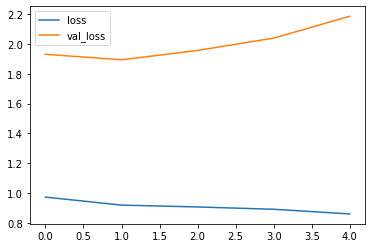

In [44]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

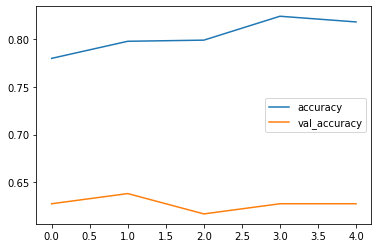

In [45]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])